# [셀프리뷰 프로젝트] 4. 캐글 제출

✔︎ 이번 프로젝트의 진행방식은 다음과 같습니다 :
- '셀프리뷰 프로젝트'는 코치의 리뷰를 거치지 않는 프로젝트입니다.
- 첨부된 파일에 안내된 절차에 따라 최소 5~10줄 이내의 간단한 코드를 작성함으로 스스로의 실력을 체크할 수 있습니다.
- 프로젝트 수행 결과 화면을 캡처 및 제출시, 담당코치가 훈련생 분의 학습현황을 파악하고 채점을 진행합니다.


✔︎ 프로젝트 수행에 어려움을 겪고 있다면?
- 만약 프로젝트 수행에 어려움을 겪고 있거나 제출을 끝냈다면, 코치 1:1 문의를 통해 예시 정답을 요청해 보세요.
- 웍스와 자유게시판을 통해 다른 훈련생들과 문제점을 공유하고 해결방안을 도모하는 것도 좋은 방법입니다.


## 1. 모델 학습하기

In [ ]:
# 앙상블 기법을 이용해 높은 성능을 가진 머신러닝을 모델을 만듭니다.
# 교차 검증을 통해 만들어진 모델의 성능을 측정합니다.

지난 프로젝트 이어서 이번에는 앙상블 기법을 활용하여 좀 더 높은 성능을 갖는 모델을 만들어 볼 것 입니다.이전 미션에 이어서 진행 할 것 입니다. 이전에 완성된 코드는 다음과 같습니다. 먼저 데이터를 다시 한번 다운로드 해오겠습니다.

In [ ]:
# 데이터 다운로드
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0' -O kaggle-kakr-housing-data.zip

In [ ]:
# 다운로드 받은 zip파일 압축풀기
!unzip -qq ./kaggle-kakr-housing-data.zip

지난 번에 작성한 전처리 코드를 실행합니다.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#--------------------------------------------------------------------------------------------------------------------------------------

train_data_path = join('./kaggle-kakr-housing-data/train.csv')
sub_data_path = join('./kaggle-kakr-housing-data/test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

#--------------------------------------------------------------------------------------------------------------------------------------
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

#--------------------------------------------------------------------------------------------------------------------------------------
y = data['price']
del data['price']

train_len = len(data)
data = pd.concat((data, sub), axis=0)

sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

#--------------------------------------------------------------------------------------------------------------------------------------
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

#--------------------------------------------------------------------------------------------------------------------------------------
y_log_transformation = np.log1p(y)

sub = data.iloc[train_len:, :] # 테스트 데이터
x = data.iloc[:train_len, :] # 학습 데이터

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 1_ 앙상블 학습

이제 본격적으로 학습시킬 모델을 준비합니다. 우리는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용합니다.

* 앙상블 기법이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다.
* 앙상블 학습에 대해서 잘 정리된 내용이 있어서 공유를 해봅니다.  : [Part 1. Introduction to Ensemble Learning](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)

앙상블은 강력한 개별 모델 하나보다 약한 여러 개의 모델의 결과를 합치는 것이 낫다는 기본 전제로부터 시작됩니다. 우리는 이번에 회귀 문제를 풀고 있으므로, 위 분류기의 앙상블처럼 투표로 정하는 대신 예측 결과를 평균 내어 활용할 예정입니다.


**Averaging**

부스팅 계열의 `gboost`, `xgboost`, `lightgbm`을 산술평균하는 앙상블 모델을 만들어볼 겁니다. 코드는 아래와 같습니다.

In [4]:
gboost = GradientBoostingRegressor(random_state=2023)
xgboost = xgb.XGBRegressor(random_state=2023)
lightgbm = lgb.LGBMRegressor(random_state=2023)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### 2_ 교차 검증 (Cross Validation)

먼저 교차 검증을 통해 모델의 성능을 측정하는 함수를 만들어 보겠습니다.

In [5]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

이제 `get_cv_score`함수에 우리의 모델을 넣고 테스트 해보겠습니다.

In [6]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8609
Model: XGBoost, CV score:0.8763
Model: LightGBM, CV score:0.8819


`cross_val_score()` 함수는 회귀모델을 전달할 경우 $R^2$ 점수를 반환합니다. $R^2$ 값은 1에 가까울수록 모델이 잘 학습되었다는 것을 나타냅니다. 결정계수 $R^2$ 값에 대한 간단한 설명은 아래의 링크 글을 참고하세요.

- [결정계수 $R^2$](https://newsight.tistory.com/259)

우리가 참가한 캐글대회에서 제공하는 Baseline 모델에서는 다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어주는 `AveragingBlending()` 함수를 만들어 사용합니다.

`AveragingBlending()` 함수는 models 딕셔너리 안에 있는 모델을 모두 `x`와 `y`로 학습시킨 뒤 `predictions`에 그 예측 결과값을 모아서 평균한 값을 반환합니다.

In [7]:
def AveragingBlending(models, x, y, sub_x):
    # 모델학습
    for m in models :
        m['model'].fit(x.values, y)

    # 모델예측
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])

    # 각 모델 에측의 평균을 return
    return np.mean(predictions, axis=1)

이제 우리의 모델에 데이터를 넣고 결과를 확인해 보겠습니다.

In [8]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 548944.53804912,  443655.17105951, 1345797.07909443, ...,
        457185.23303678,  339532.04977609,  422564.70651683])

적당한 실수값들로 예측을 해낸 것 같습니다.

## 2. 대회 참여하기

In [9]:
# 모델 예측 결과를 csv 파일로 저장합니다.
# 저장한 csv 파일을 대회에 제출하고, Public Score를 확인합니다.

### [TODO] 3_ 제출용 샘플 만들기

그렇다면 우리는 이 결과를 캐글에 제출하기 위해 어떻게 해야 할까요?

제출해야 하는 csv 파일의 샘플이 바로 `data` 폴더에 있는 `sample_submission.csv` 입니다.
다음 코드로 `sample_submission.csv` 파일을 확인해보겠습니다.

In [12]:
submission = pd.read_csv('./kaggle-kakr-housing-data/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


제출 파일은 `id`와 `price` 두 가지 열로 구성되어 있습니다. 그렇다면 우리도 `id`와 `price`로 구성된 데이터 프레임을 만들어 주도록 하겠습니다.

In [13]:
result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.489445e+05
1,15036,4.436552e+05
2,15037,1.345797e+06
3,15038,3.206119e+05
4,15039,3.180479e+05


이제 완전히 준비가 끝났습니다. 이때 활용할 수 있는 함수는 [`to_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)함수 입니다.
샘플 형태인 `sample_submission.csv`를 로드했을 때와 동일한 형식으로 저장해야만 정확하게 제출될 것 입니다.

In [16]:
# 저장할 파일명은 submission.csv로 하였습니다.
my_submission_path = './kaggle-kakr-housing-data/submission.csv'

# result를 'my_submission_path'란 이름의 csv로 저장해 주세요.

#######################################
#### 4-1. 알맞은 코드를 직접 작성해보세요! ####
#######################################
result.to_csv(my_submission_path, index=False)
print(f"Result has been saved to {my_submission_path}")

Result has been saved to ./kaggle-kakr-housing-data/submission.csv


### 4_ Baseline 모델 학습 결과를 제출해보기

일단 저장된 `submission.csv` 파일을 아래의 그림과 같이 여러분의 컴퓨터로 다운로드 하겠습니다. (Colab에서 진행하는게 아니라면 무시하셔도 됩니다. 이미 여러분의 로컬 컴퓨터에 저장되어 있을테니까요)

Colab의 경우 아래의 그림처럼 왼쪽의 폴더 모양을 누르신 후 `data`폴더에서 `submission.csv` 파일을 선택하신 후 다운로드 해주세요.

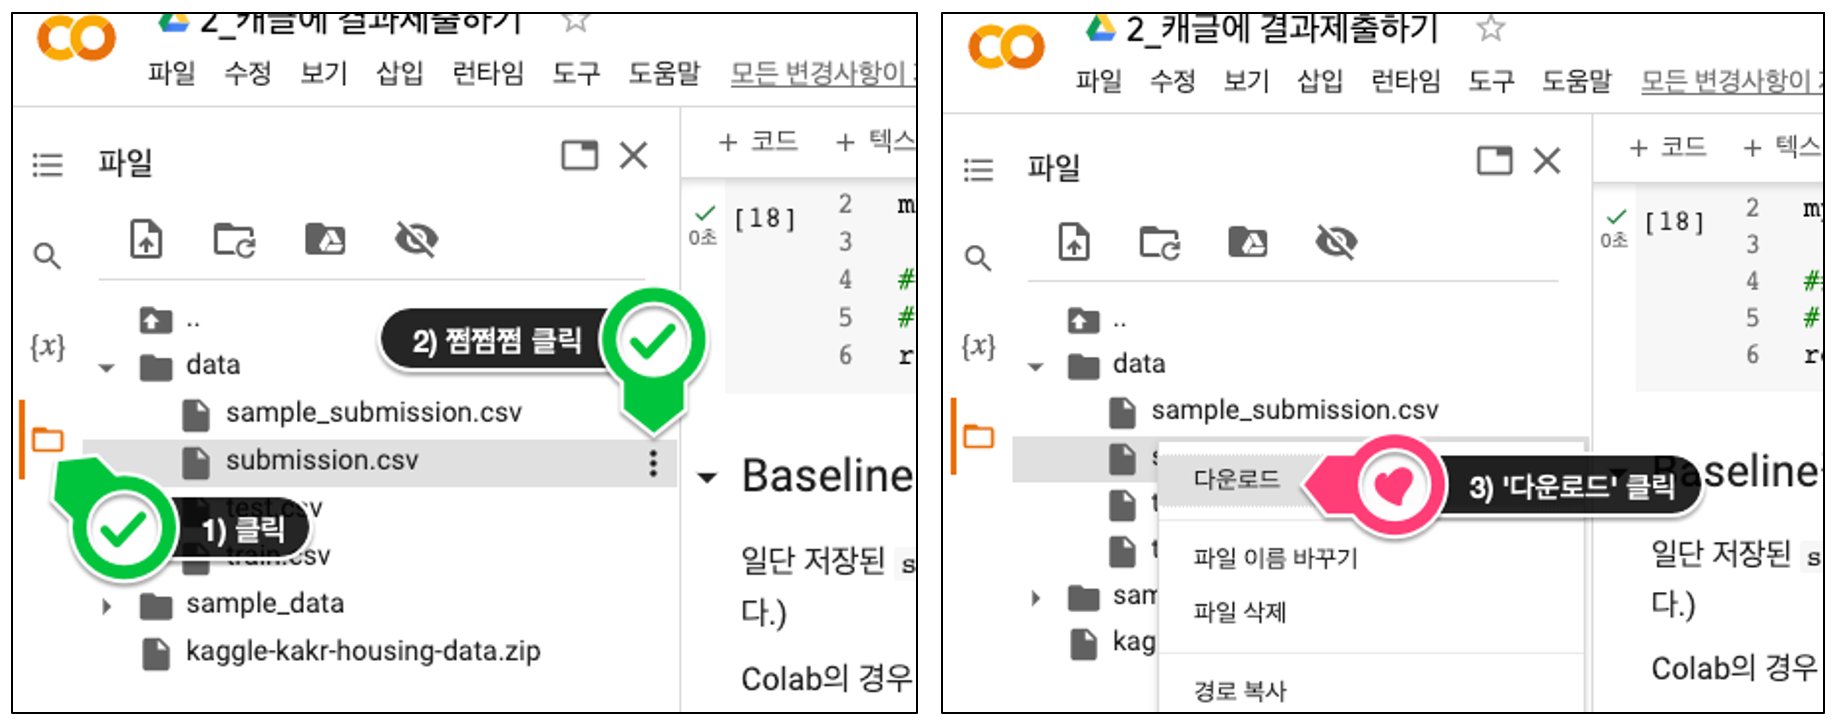

**캐글 사이트에 제출하기**

이제 다운로드 받은 파일을 제출해볼것 입니다.
앞서 말했다시피 이번 대회는 이미 끝난 대회이기 때문에 `Late Submission`만 가능한 상태입니다.
아래와 같이 탭에 있는 `Late Submission `버튼을 클릭하면 다음과 같은 화면을 만날 수 있습니다 (**로그인을 하셔야 제출하실 수 있습니다.**)

- [캐글 코리아와 함께하는 2nd ML대회](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

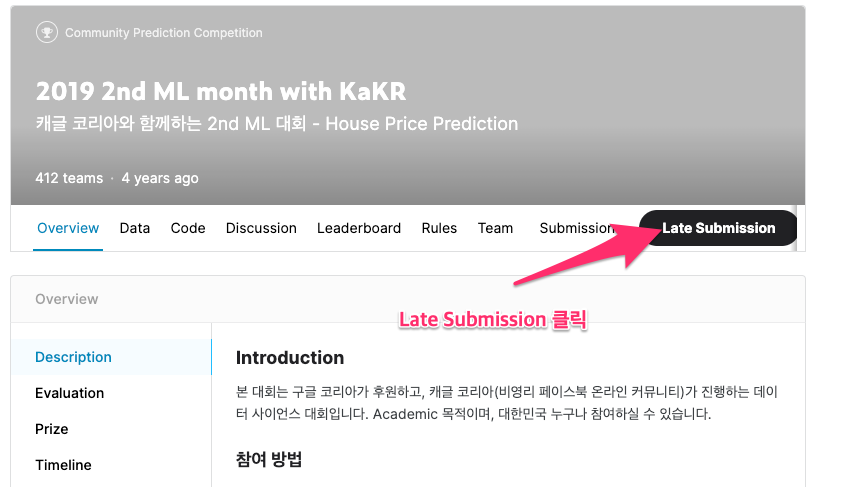

이제 여러분이 다운로드 받은 파일을 drag&drop으로 제출해주세요.
**제출할때 메세지까지 작성해주셔야 '제출버튼'이 활성화 될 것 입니다.** 활성화되면 제출을 완료해주세요. 완료되면 다음과 같은 화면이 나타날 겁니다.

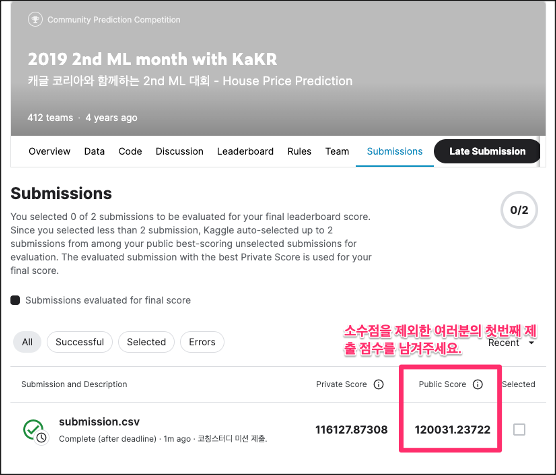

**제출결과 확인하기**

여러분이 제출한 Public Score는 몇점이신가요? 이 대회는 지난 대회이기 때문에 여러분의 결과가 Leaderboard에 등록되지 않습니다. 그러나 여러분의 결과가 어느정도 순위인지 Leaderboard를 통해서 직접 확인해 보실 수는 있습니다.

## 3. 셀프리뷰 진행하기

- 수행한 프로젝트 내용을 확인하고, 셀프리뷰를 진행합니다.
- 내가 작성한 코드에 오류는 없는지 또는 더 나은 방법은 없는지 고민해 봅니다.
- 리뷰를 완료했다면, 실행 결과 화면을 캡쳐 및 제출하여 수행여부를 증빙합니다. (파일첨부 NO! 본문에 이미지 삽입 YES!)
- 이번 차시에 궁금한 점이 있다면, 제출시 본문에 내용을 함께 작성하여 제출할 수 있습니다.

ALL RIGHTS RESERVED. (C)NAVER Connect Foundation.